The script demonstrates how the code can be used with a toy example (see also [this blogpost](https://andreasloukas.blog/2018/11/05/multilevel-graph-coarsening-with-spectral-and-cut-guarantees/)).

The code accompanies paper [Graph reduction with spectral and cut guarantees](http://www.jmlr.org/papers/volume20/18-680/18-680.pdf) by Andreas Loukas published at JMLR/2019 ([bibtex](http://www.jmlr.org/papers/v20/18-680.bib)).

This work was kindly supported by the Swiss National Science Foundation (grant number PZ00P2 179981).

15 March 2019

[Andreas Loukas](https://andreasloukas.blog)

[![DOI](https://zenodo.org/badge/175851068.svg)](https://zenodo.org/badge/latestdoi/175851068)

Released under the Apache license 2.0

In [1]:
!pip install networkx

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

/tmp/ipykernel_82274/912229180.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display, HTML


In [5]:
from graph_coarsening.coarsening_utils import *
import graph_coarsening.graph_utils

import numpy as np
import scipy as sp

import matplotlib
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D

import networkx as nx
import pygsp as gsp
from pygsp import graphs
gsp.plotting.BACKEND = 'matplotlib'

### Construct the graph ## 

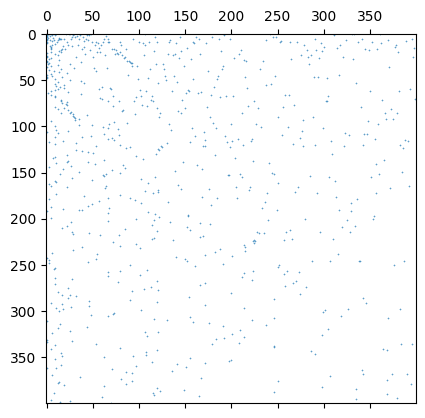

In [6]:
N = 400

G = graphs.BarabasiAlbert(N)
if not hasattr(G, 'coords'): 
    try:
        # graph = nx.from_scipy_sparse_matrix(G.W)
        graph = nx.from_scipy_sparse_array(G.W)
        pos = nx.nx_agraph.graphviz_layout(graph, prog='neato')  
        G.set_coordinates(np.array(list(pos.values()))) 
    except ImportError:
        G.set_coordinates()
    G.compute_fourier_basis() # this is for convenience (not really needed by coarsening)
    
N = G.N
L = G.L.toarray()
S = graph_coarsening.graph_utils.get_S(G).T

plt.spy(G.W, markersize=0.2);

### Do some coarsening

* Possible methods supported are: 'variation_edges', 'variation_neighborhood', 'algebraic_JC', 'heavy_edge', 'affinity_GS'
* $r = 1 - n/N$ is the dimensionality reduction ratio
* $k$ is the size of the subspace we are interested in
* $k_{max}$ should be set to be larger or equal to $k$. It allows us to measure the quality of coarsening over subspaces larger than $k$.

In [10]:
method = 'variation_neighborhood'  

# Parameters
r    = 0.6 # the extend of dimensionality reduction (r=0 means no reduction)
k    = 5  
kmax = int(3*k)
        
C, Gc, Call, Gall = coarsen(G, K=k, r=r, method=method) 
metrics = coarsening_quality(G, C, kmax=kmax)
n = Gc.N

print('{:16} | r: {:1.4}, nedges: {}, levels: {}, epsilon: {:1.4}'.format(method, metrics['r'], metrics['m'], len(Call), metrics['error_subspace'][k-1]))

variation_neighborhood | r: 0.5975, nedges: 160, levels: 2, epsilon: 0.0179


### Visualize the sequence of coarsening levels

* $c+1$ graphs are plotted in total. The leftmost is the original graph and the rightmost is the final coarse graph. 
* Colors are used to indicate the size of each contraction set $C$: 
    * green is for $|C|=2$  blue is for $|C|=3$, red is for $|C|=4$, and yellow for $|C|>4$


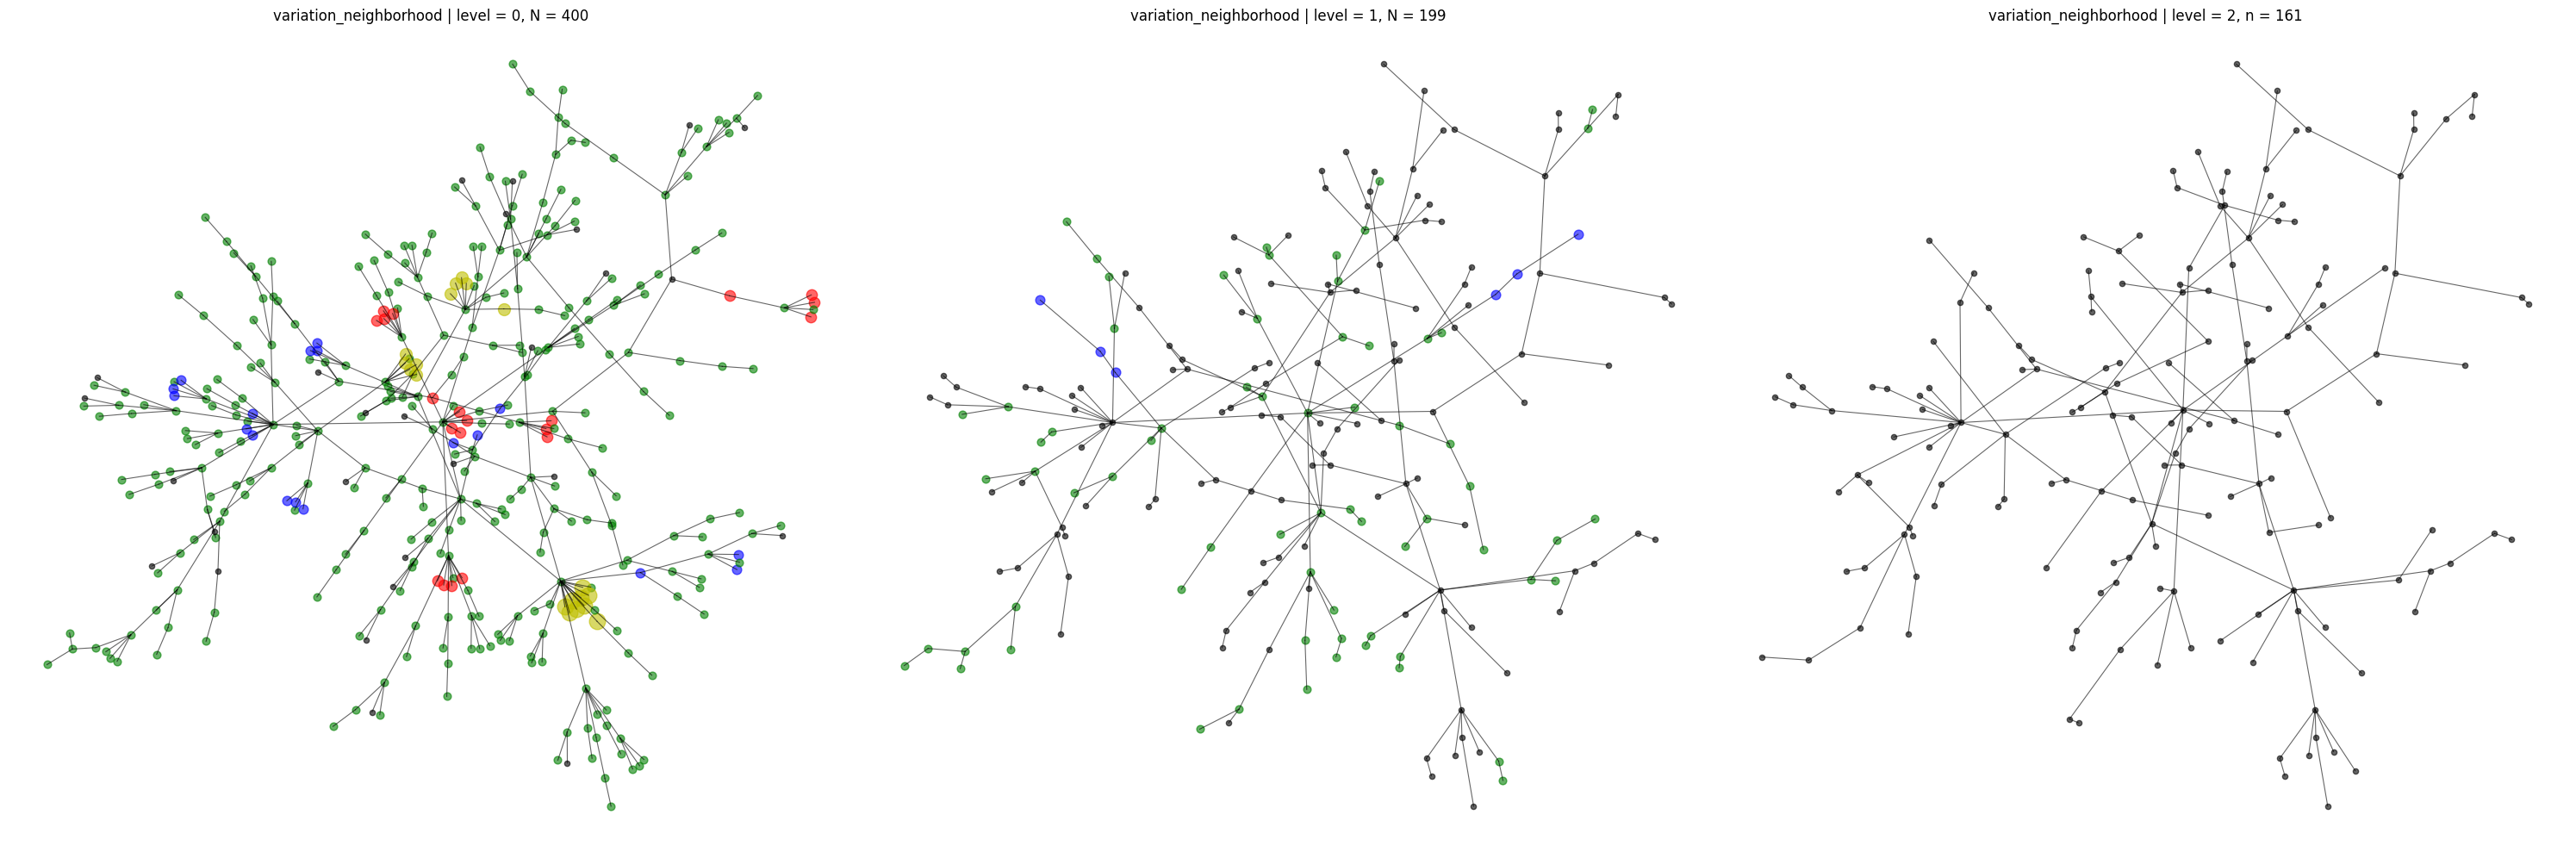

In [12]:
plot_coarsening(Gall, Call, size=5, alpha=0.6, title=method);

### Various metrics for coarsening quality

* $\epsilon$ is the restricted similarity constant such that, for every $x \in span(U_k)$ we have $$(1 - \epsilon) x^\top L x \leq x_c^\top L_c x_c \leq (1+\epsilon) x^\top L x $$   
* the eigenvalue error is defined (for every $i = 1, \ldots, k, \ldots, kmax$ as $\frac{\lambda_i - \tilde{\lambda}_i}{\lambda_i}$
* the angle matrix contains the angles between the eigenvectors of $L$ (y-axis) and the lifted eigenvectors of $L_c$. The closer to counter-diagonal it is, the better.

<>:4: SyntaxWarning: invalid escape sequence '\e'
<>:4: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_82274/1453090088.py:4: SyntaxWarning: invalid escape sequence '\e'
  axes[0].set_xlabel('$k$'); axes[0].set_ylabel('$\epsilon$')


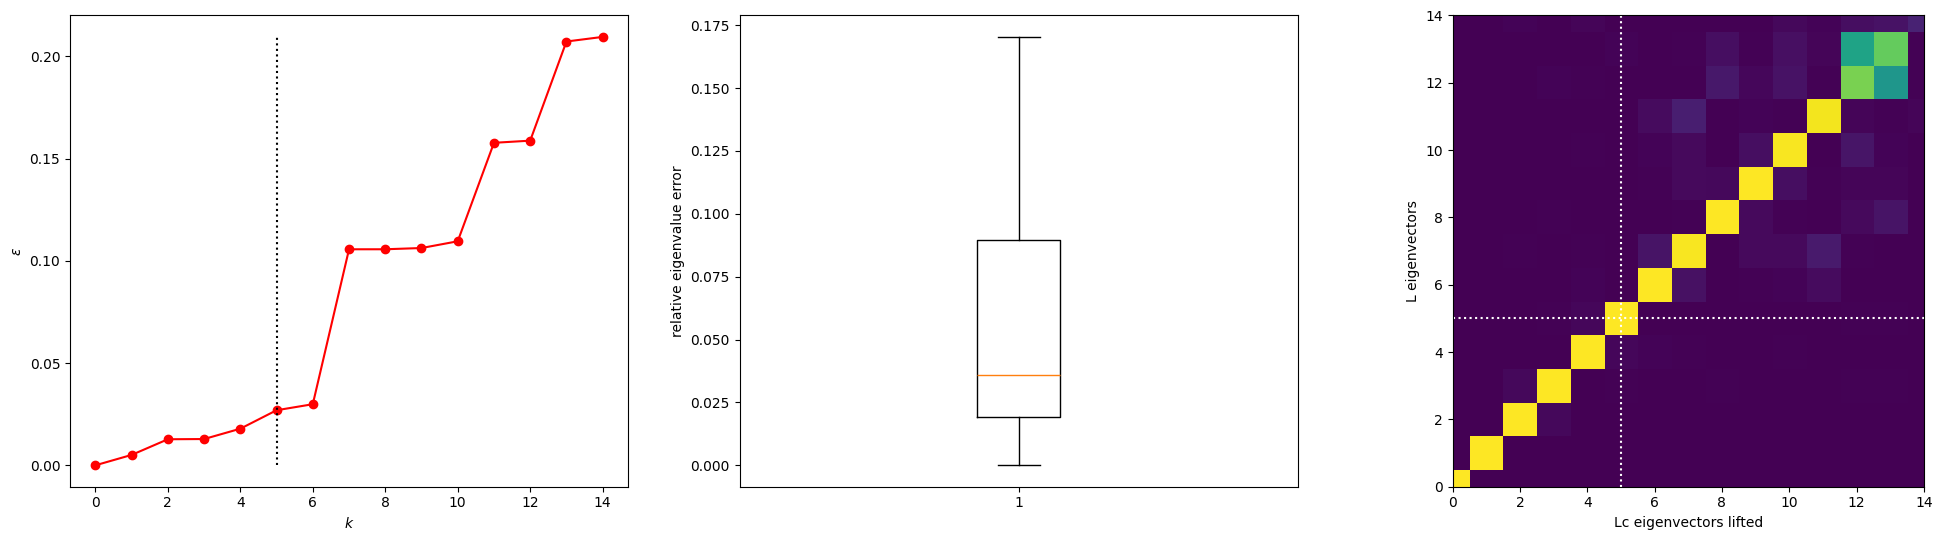

In [13]:
size = 2.04; fig, axes = plt.subplots(1, 3, figsize=(4*size*3, 3*size)); lineWidth = 1

axes[0].plot(np.arange(kmax), np.abs(metrics['error_subspace']), 'or-') 
axes[0].set_xlabel('$k$'); axes[0].set_ylabel('$\epsilon$')
axes[0].plot( [k, k], [0, max(metrics['error_subspace'])], ':k') 

axes[1].boxplot(np.abs(metrics['error_eigenvalue'])) 
axes[1].set_ylabel('relative eigenvalue error')

axes[2].imshow(abs(metrics['angle_matrix'][:,0:kmax]) )
axes[2].plot( [k, k], [0, kmax], ':w') 
axes[2].plot( [0, kmax], [k, k], ':w') 
axes[2].plot( [0, N], [n-1, n-1], ':w') 
axes[2].set_xlim([0, kmax-1])
axes[2].set_ylim([0, kmax-1])
axes[2].set_xlabel('Lc eigenvectors lifted'); axes[2].set_ylabel('L eigenvectors');

### Coarsen and lift a vector

signal error: 0.007105087324321169


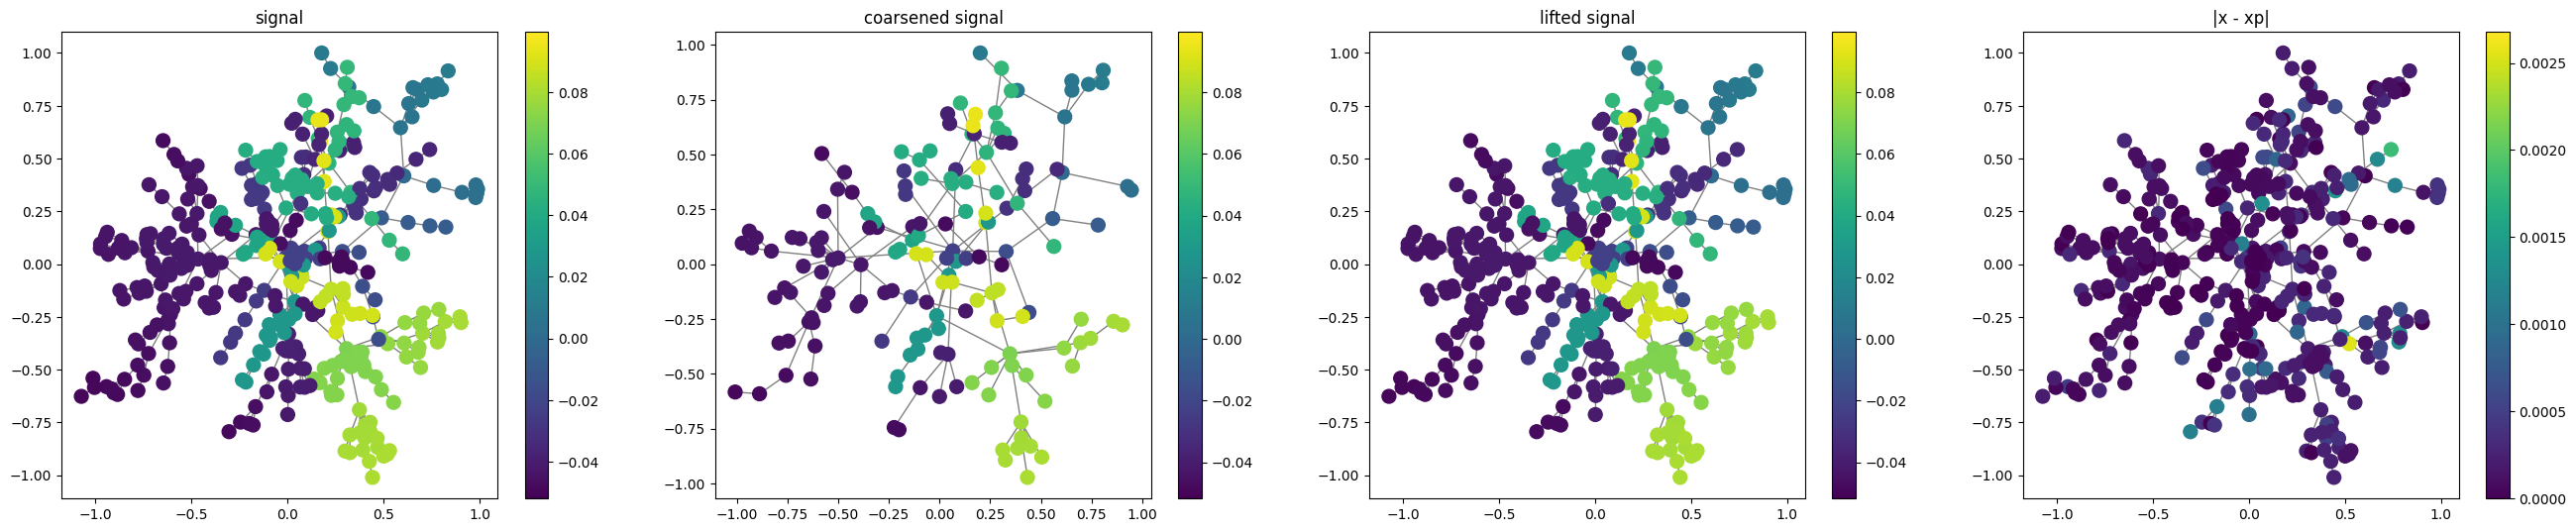

In [14]:
size = 2.04; fig, axes = plt.subplots(1, 4, figsize=(4*size*4, 3*size)); lineWidth = 1

# a random smooth signal 
x = G.U[:,:k] @ np.random.randn(k,1)
x = x / np.linalg.norm(x)
G.plot_signal(x, ax=axes[0], plot_name='signal')

# coarsen it 
xc = coarsen_vector(x, C)
Gc.plot_signal(xc, ax=axes[1], plot_name='coarsened signal')

# lift it 
xp = lift_vector(xc, C)
G.plot_signal(xp, ax=axes[2], plot_name='lifted signal')

# difference
G.plot_signal(np.abs(x-xp), ax=axes[3], plot_name='|x - xp|')

print('signal error: {}'.format(np.linalg.norm(x - xp)))